# Basic analysis of the short reviews

In [1]:
import numpy as np
import pandas as pd
import re
import time
import random
import csv
import openpyxl

## libs for initial analysis
import matplotlib.pyplot as plt
import matplotlib
import jieba
import jieba.analyse
from wordcloud import WordCloud
from collections import Counter

In [2]:
## setup the chinese font for matplotlib.pyplot
plt.rcParams['font.sans-serif'] = 'SimHei'

## setup the font path for wordcloud
FONT_PATH = "STHeiti Medium.ttc"

In [3]:
comment_df = pd.read_csv('comment_data_local.csv')

In [4]:
len(comment_df)

4300

In [5]:
comment_df_no_dup = comment_df.drop_duplicates(subset=comment_df.columns.difference(['source']))
mask = comment_df_no_dup['star'].apply(lambda x: x.isnumeric())
stared_comment = comment_df_no_dup[mask].copy()

In [6]:
len(stared_comment)

2010

In [7]:
def star_pie_chart(df):
    score = dict(df['star'].value_counts(dropna=False))
    count = len(df)
    
    ## setup for pie chart
    label = '1分', '2分', '3分', '4分', '5分'
    color = 'blue', 'orange', 'yellow', 'green', 'red'  # 各类别颜色
    size = {}  # 一个百分比数字 合起来为100
    explode = {}  # explode :(每一块)离开中心距离；
    
    for i in range(1, 6):  # 计算
        size[str(i)] = score[str(i)] * 100 / count
        explode[str(i)] = score[str(i)] / count / 10
    
    pie = plt.pie(size.values(), colors=color, explode=explode.values(), labels=label, shadow=True, autopct='%1.1f%%')
    for font in pie[1]:
        font.set_size(8)
    for digit in pie[2]:
        digit.set_size(8)
    plt.axis('equal')  # 该行代码使饼图长宽相等
    plt.title(u'各个评分占比', fontsize=12)  # 标题
    plt.legend(loc=0, bbox_to_anchor=(0.82, 1))  # 图例
    # 设置legend的字体大小
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=6)
    plt.savefig("score.png")
    plt.show()

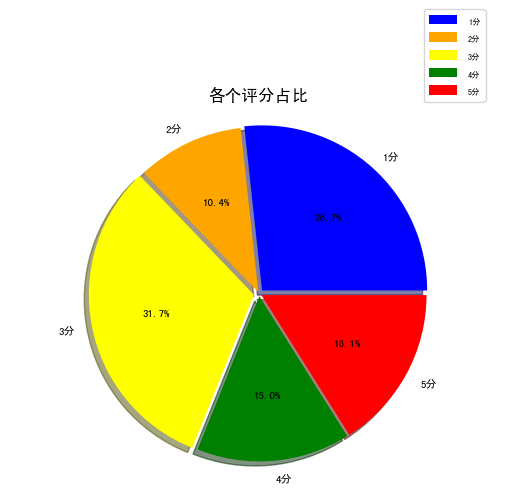

In [8]:
star_pie_chart(stared_comment)

In [9]:
commentstr = ''  # 评论的字符串
c = Counter()  # python一种数据集合，用来存储字典
index = 0

In [10]:
for i in stared_comment['comment']:
    seg_list = jieba.cut(i,cut_all=False)
    index += 1
    for x in seg_list:
        if len(x)>1 and x != '\r\n':
            try:
                c[x] += 1
            except:
                continue
    commentstr += i

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/pp/zqcpgy9519n3pv2zd3tbtbhr0000gn/T/jieba.cache
Loading model cost 0.311 seconds.
Prefix dict has been built successfully.


<span style='color: red'>Stop words sould be learned from multiple docs (multiple movies)</span>

In [11]:
list = ['这个', '一个', '不少', '起来', '没有', '就是', '不是', '那个', '还是', '剧情', '这样', '那样', '这种', '那种', '故事', '人物', '什么']

In [12]:
comment_lists = stared_comment['comment'].to_list()

In [13]:
comment_lists.sort()

In [14]:
comment_lists[:10]

['\tsrds，希恩斯这个“人脑开发”的计划成功的前提得是三体人的技术发展相对静止或者速度比人类慢吧，不然在时间相同的情况下，差距依然存在啊。。。',
 '\n不要删减，不要删减，不要删减。\n\n还是可以的，只是没想到古筝行动在第一集开头，记得看书的时候古筝行动让我觉得是一个小高潮。\n',
 '\n宇宙中最浪漫的事情，就是为喜欢的动画送上一颗星星',
 '  看完两集，王淼，大史，叶文洁，罗辑，丁仪人设崩了（你们这剧组是真的牛逼，两集崩了五个人设）\n  地球往事一刀全剪掉，原著好好的台球实验不用那跟笔砸纸，复杂化装nm呢。几百颗质子变成五颗你是懂删减的，实验失败就开启面壁计划你们是懂赶工的。\n  怎么这么烂啊！！！！原著党不想帮洗啊！！！',
 '"想想吧，2019年的上海堡垒，吊在耻辱柱上才几年哪？忘了！那扇被重新关上的中国科幻电影的大门，还天天的盯着你们呢！原著党已经三天三夜没有合眼了，总想着和大伙说些什么，可是话，总得有个头啊 。想来想去，只有四个字［尊重原著］……这四个字，说说容易啊，身体力行又何其难？ "',
 '#学习动画三年#的建模水平',
 '02看完',
 '1. 离开动画行业好一阵了，终于可以事不关己地骂一骂，五六年来你们动画CG技术几乎毫无进步。\n2. 人物演出太幼稚了。想象人类命运交到这些小P孩心智的人手上，你安心吗？\n3. 音乐铺太满，完全破坏了身临其境感。',
 '1.如果用一个词形容的话就是尴尬。一方面故事情节跳动太多，非原著党根本无法理解整个故事的前因后果，另一方面又大搞故意省略关键信息，想搞悬疑情节，吸引观众，这就造成了这种尴尬的局面：非原著党看着一脸懵B，原著党是看着你怎么装B。2.介绍的单集片长是40分钟，其实正片也就28分钟，这还算上片头广告，序幕、片中广告、片尾曲，下集预告。实际内容也就20来分钟，虚报严重啊。3.不是为什么，我儿子从三岁时候就对我书架上的一套《三体》封面及彩页非常感兴趣，经常拿下来玩，现在将近六岁，看了两集动画后，对三体故事很感兴趣，我也得以把故事讲给他听，粒子对撞实验、四维空间、发送星球坐标引导外星文明毁灭、水滴等等概念都非常喜欢。4.最后说一点，就这动画质量还一周更新一集，逼着观众放弃啊',
 '12.10挺不错的。就是把罗辑约炮的对象的设定改了，就缺少了罗辑玩世不恭、看破红尘的性格。古筝

In [15]:
for i in jieba.cut(comment_lists[8],cut_all=False):
    print(i)

1
.
如果
用
一个
词
形容
的话
就是
尴尬
。
一方面
故事情节
跳动
太
多
，
非
原著
党
根本无法
理解
整个
故事
的
前因后果
，
另一方面
又
大
搞
故意
省略
关键
信息
，
想
搞
悬疑
情节
，
吸引
观众
，
这
就
造成
了
这种
尴尬
的
局面
：
非
原著
党
看着
一脸
懵
B
，
原著
党
是
看着
你
怎么
装
B
。
2
.
介绍
的
单集
片长
是
40
分钟
，
其实
正片
也
就
28
分钟
，
这
还
算
上
片头
广告
，
序幕
、
片中
广告
、
片尾曲
，
下集
预告
。
实际
内容
也
就
20
来
分钟
，
虚报
严重
啊
。
3
.
不是
为什么
，
我
儿子
从
三岁
时候
就
对
我
书架上
的
一套
《
三体
》
封面
及彩页
非常
感兴趣
，
经常
拿
下来
玩
，
现在
将近
六岁
，
看
了
两集
动画
后
，
对三体
故事
很感兴趣
，
我
也
得以
把
故事
讲
给
他
听
，
粒子
对撞
实验
、
四维空间
、
发送
星球
坐标
引导
外星
文明
毁灭
、
水滴
等等
概念
都
非常
喜欢
。
4
.
最后
说
一点
，
就
这
动画
质量
还
一周
更新
一集
，
逼
着
观众
放弃
啊


In [16]:
c.most_common(100)

[('原著', 493),
 ('三体', 481),
 ('动画', 373),
 ('剧情', 263),
 ('就是', 226),
 ('罗辑', 221),
 ('还是', 189),
 ('建模', 187),
 ('这个', 183),
 ('没有', 181),
 ('可以', 177),
 ('改编', 169),
 ('人物', 163),
 ('看过', 161),
 ('不是', 159),
 ('觉得', 159),
 ('什么', 150),
 ('真的', 141),
 ('一个', 138),
 ('故事', 134),
 ('感觉', 133),
 ('不错', 131),
 ('画面', 131),
 ('这么', 115),
 ('两集', 114),
 ('计划', 105),
 ('出来', 103),
 ('古筝', 99),
 ('但是', 99),
 ('已经', 97),
 ('知道', 97),
 ('这样', 94),
 ('人类', 93),
 ('第一部', 93),
 ('期待', 91),
 ('面壁', 91),
 ('好看', 91),
 ('怎么', 90),
 ('有点', 90),
 ('小说', 89),
 ('水平', 87),
 ('开始', 86),
 ('不能', 85),
 ('直接', 85),
 ('第一集', 84),
 ('那么', 83),
 ('作品', 83),
 ('观众', 83),
 ('这种', 82),
 ('喜欢', 80),
 ('确实', 79),
 ('制作', 77),
 ('一些', 77),
 ('现在', 76),
 ('艺画', 76),
 ('叶文洁', 75),
 ('看到', 73),
 ('很多', 73),
 ('一样', 72),
 ('节奏', 72),
 ('可能', 72),
 ('细节', 71),
 ('第三集', 71),
 ('如果', 70),
 ('自己', 69),
 ('还有', 68),
 ('不要', 67),
 ('一下', 67),
 ('一集', 65),
 ('理解', 65),
 ('编剧', 65),
 ('时候', 65),
 ('完全', 64),
 ('问题', 62),
 ('科幻',

In [17]:
x = []
y = []
for k, v in c.most_common(100):
    x.append(k)
    y.append(v)
xi = x[0:50]
xi = ' '.join(xi)
print(xi)

原著 三体 动画 剧情 就是 罗辑 还是 建模 这个 没有 可以 改编 人物 看过 不是 觉得 什么 真的 一个 故事 感觉 不错 画面 这么 两集 计划 出来 古筝 但是 已经 知道 这样 人类 第一部 期待 面壁 好看 怎么 有点 小说 水平 开始 不能 直接 第一集 那么 作品 观众 这种 喜欢


In [18]:
wc = WordCloud(background_color="white",
               width=1500, height=1200,
               # min_font_size=40,
               # # mask=backgroud_Image,
               font_path=FONT_PATH,
               max_font_size=150,  # 设置字体最大值
               random_state=50,  # 设置有多少种随机生成状态，即有多少种配色方案
               )

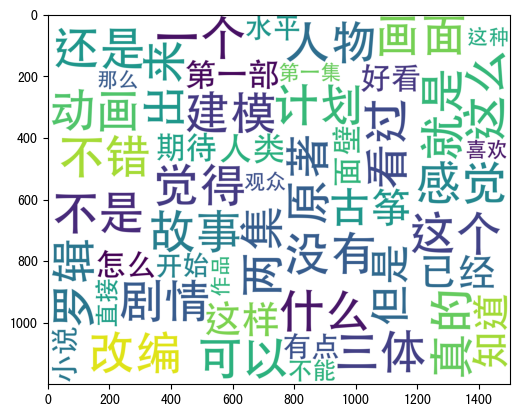

In [20]:
my_wordcloud = wc.generate(xi)  #需要放入词云的单词 ，这里前150个单词
plt.savefig('wordcloud.png')
plt.imshow(my_wordcloud) 